# Playground for Ensemble Slides

- Stephen W. Thomas
- Used for MMA 869, MMAI 869, and GMMA 869

In [1]:
import datetime
print(datetime.datetime.now())

2019-04-15 16:00:50.502390


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import itertools

import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Resampling Strategies

In [3]:
from sklearn.model_selection import ShuffleSplit
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [3, 4], [5, 6]])
y = np.array([1, 2, 1, 2, 1, 2])
rs = ShuffleSplit(n_splits=10, test_size=.25, random_state=0)
rs.get_n_splits(X)
print(rs)
for train_index, test_index in rs.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

10

ShuffleSplit(n_splits=10, random_state=0, test_size=0.25, train_size=None)
TRAIN: [1 3 0 4] TEST: [5 2]
TRAIN: [4 0 2 5] TEST: [1 3]
TRAIN: [1 2 4 0] TEST: [3 5]
TRAIN: [3 4 1 0] TEST: [5 2]
TRAIN: [3 5 1 0] TEST: [2 4]
TRAIN: [4 2 0 5] TEST: [3 1]
TRAIN: [2 4 5 3] TEST: [0 1]
TRAIN: [3 4 1 0] TEST: [5 2]
TRAIN: [4 5 2 0] TEST: [3 1]
TRAIN: [0 5 4 2] TEST: [1 3]


In [4]:
from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [3, 4], [5, 6]])
y = np.array([1, 2, 1, 2, 1, 2])
rs = KFold(n_splits=2, random_state=0)
rs.get_n_splits(X)
print(rs)
for train_index, test_index in rs.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

2

KFold(n_splits=2, random_state=0, shuffle=False)
TRAIN: [3 4 5] TEST: [0 1 2]
TRAIN: [0 1 2] TEST: [3 4 5]


In [5]:
# After experiementation, this random state generates a "good looking" dataset
r = 4184

X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, flip_y=0.09, class_sep = 1.1, random_state=r);
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

feature_names = ['Age', 'Income']

In [6]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc

# Adopted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

def plot_boundaries(X_train, X_test, y_train, y_test, clf, clf_name, ax, hide_ticks=True):
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02));
    
    
    #score = clf.score(X_test, y_test);
    y_pred_tmp = clf.predict(X_test)
    score_str = "acc={:.2f}, kappa={:.2f}, f1={:.2f}".format(
        accuracy_score(y_test, y_pred_tmp),
        cohen_kappa_score(y_test, y_pred_tmp),
        f1_score(y_test, y_pred_tmp))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]);
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1];

    # Put the result into a color plot
    Z = Z.reshape(xx.shape);
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8);

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap=cm_bright, edgecolors='k');
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cm_bright, edgecolors='k', alpha=0.6);

    ax.set_xlim(xx.min(), xx.max());
    ax.set_ylim(yy.min(), yy.max());
    if hide_ticks:
        ax.set_xticks(());
        ax.set_yticks(());
    else:
        ax.tick_params(axis='both', which='major', labelsize=18);
        #ax.yticks(fontsize=18);
        
    ax.set_title(clf_name, fontsize=28);
    ax.text(xx.max() - .3, yy.min() + .3, score_str, size=22, horizontalalignment='right');
    ax.grid();
    
    


def plot_roc(clf, X_test, y_test, name, ax, show_thresholds=True):
    y_pred_rf = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, y_pred_rf)

    ax.plot([0, 1], [0, 1], 'k--');
    ax.plot(fpr, tpr, label='{}, AUC={:.2f}'.format(name, auc(fpr, tpr)));
    ax.scatter(fpr, tpr);

    if show_thresholds:
        for i, th in enumerate(thr):
            ax.text(x=fpr[i], y=tpr[i], s="{:.2f}".format(th), fontsize=14, 
                     horizontalalignment='left', verticalalignment='top', color='black',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.1));
        
    ax.set_xlabel('False positive rate', fontsize=18);
    ax.set_ylabel('True positive rate', fontsize=18);
    ax.tick_params(axis='both', which='major', labelsize=18);
    ax.grid(True);
    ax.set_title('ROC Curve', fontsize=18)

## Committee/Voting

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)

classifiers = [('DT', clf1), ('KNN', clf2), ('SVM', clf3)]

cclf = VotingClassifier(estimators=classifiers, voting='soft', weights=[2, 1, 2])


clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)
clf3 = clf3.fit(X_train, y_train)
cclf = cclf.fit(X_train, y_train)

C:\Users\st50\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Text(0.5, 1.0, 'DT')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Income')

Text(0.5, 1.0, 'KNN')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Income')

Text(0.5, 1.0, 'SVM')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Income')

C:\Users\st50\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\st50\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5, 1.0, 'Committee')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Income')

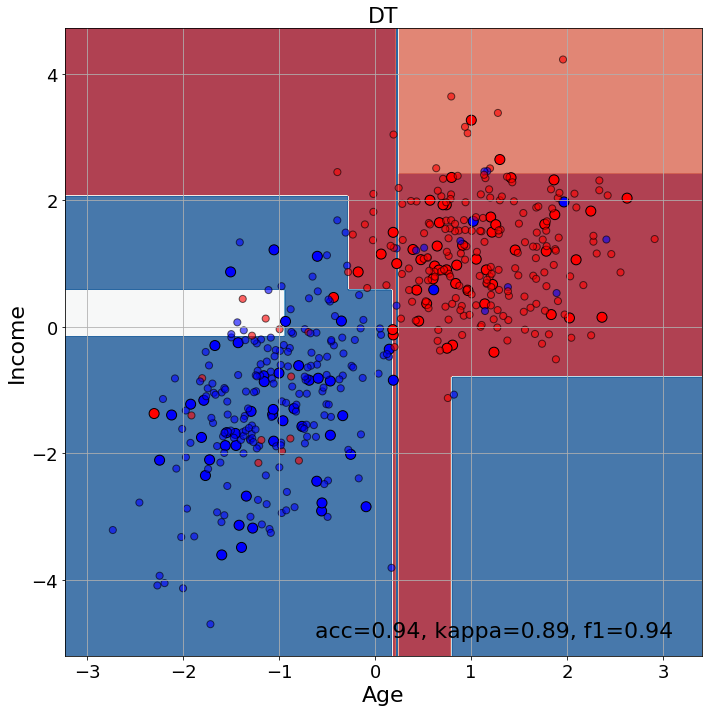

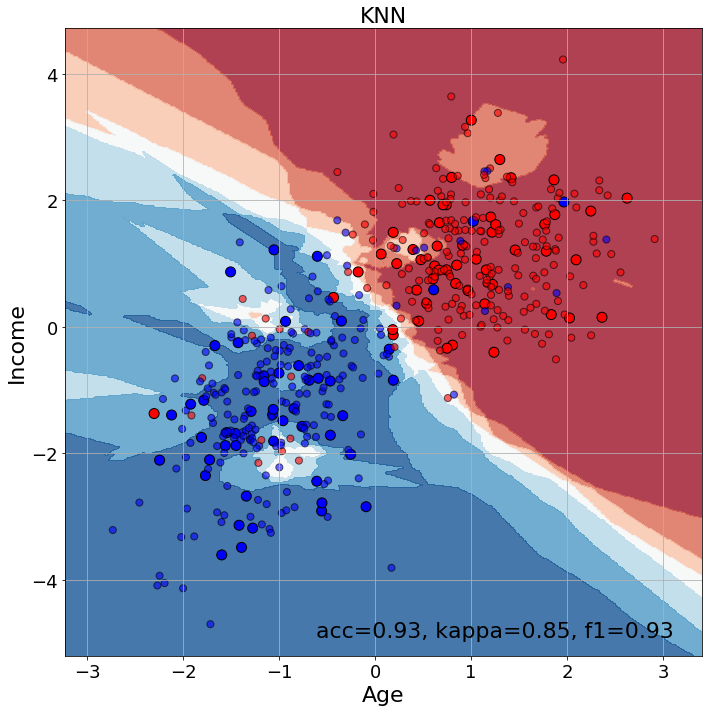

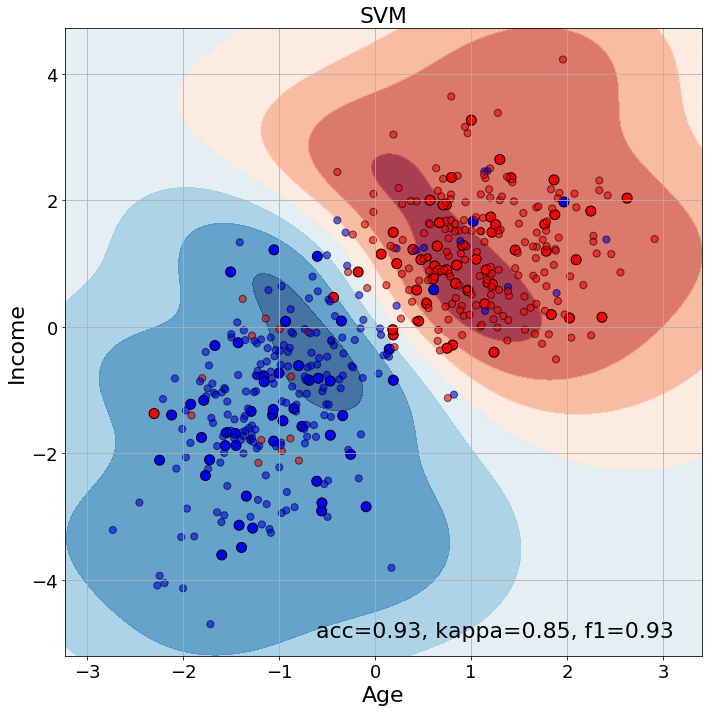

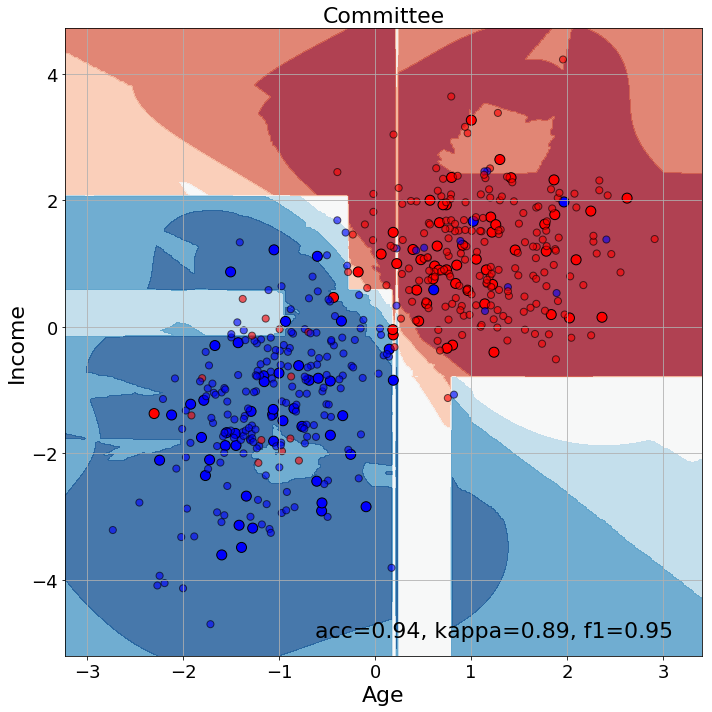

In [8]:
classifiers = classifiers + [('Committee', cclf)]

for clf_name, clf_tmp in classifiers:
    y_pred_tmp = clf_tmp.predict(X_test)
    
    figure = plt.figure(figsize=(10, 10));
    ax = plt.subplot(1, 1, 1);
    plot_boundaries(X_test, X_train, y_test, y_train, clf_tmp, "", ax, hide_ticks=False);
    ax.set_title(clf_name, fontsize=22);
    ax.set_xlabel("Age", fontsize=22);
    ax.set_ylabel("Income", fontsize=22);
    plt.tight_layout();
    plt.savefig('out/default-voting-{}-boundaries.png'.format(clf_name));

# Bagging (with DTs)

In [9]:
from sklearn.ensemble import BaggingClassifier

clf_bag = BaggingClassifier(
    DecisionTreeClassifier(max_depth=None, min_samples_split=2),
    n_estimators=100, max_samples=.10, max_features=0.5,random_state=0)
clf_bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.1, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=0, verbose=0, warm_start=False)

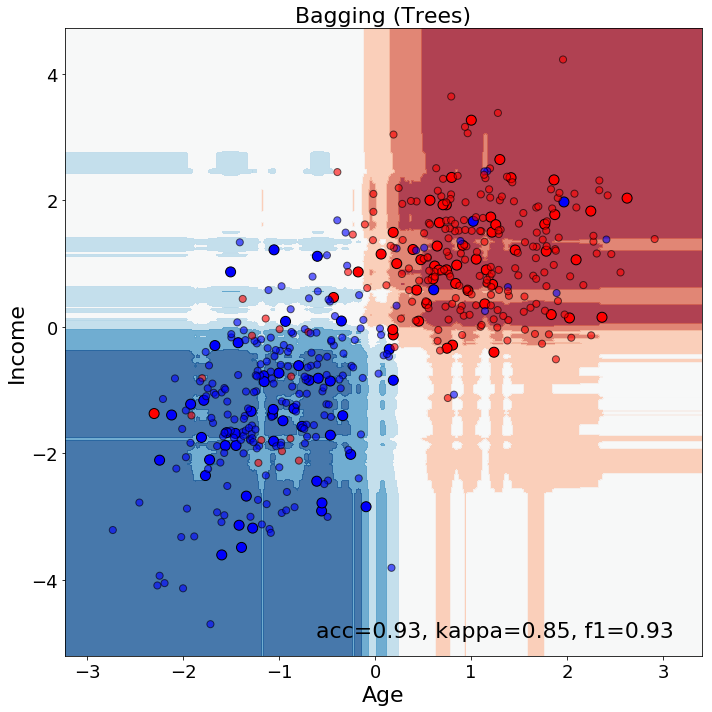

In [10]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_test, X_train, y_test, y_train, clf_bag, "", ax, hide_ticks=False);
ax.set_title("Bagging (Trees)", fontsize=22);
ax.set_xlabel("Age", fontsize=22);
ax.set_ylabel("Income", fontsize=22);
plt.grid();
plt.tight_layout();
plt.savefig('out/default-bagging-boundaries.png');

Wall time: 6.13 s


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D7EB0F2470>,
        cv=5, groups=None, logx=False, model=None, n_jobs=1,
        param_name='n_estimators',
        param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
        pre_dispatch='all', scoring='roc_auc')

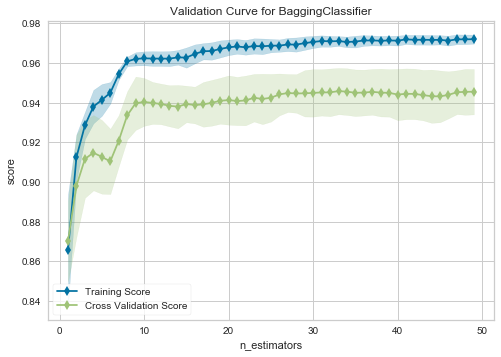

In [11]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve( BaggingClassifier(
    DecisionTreeClassifier(max_depth=None, min_samples_split=2),
    max_samples=.10, max_features=0.5,random_state=0), param_name="n_estimators", param_range=np.arange(1, 50), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='out/default-bagging-n_estimators.png')
viz.poof()

# Random Forests

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(
    n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

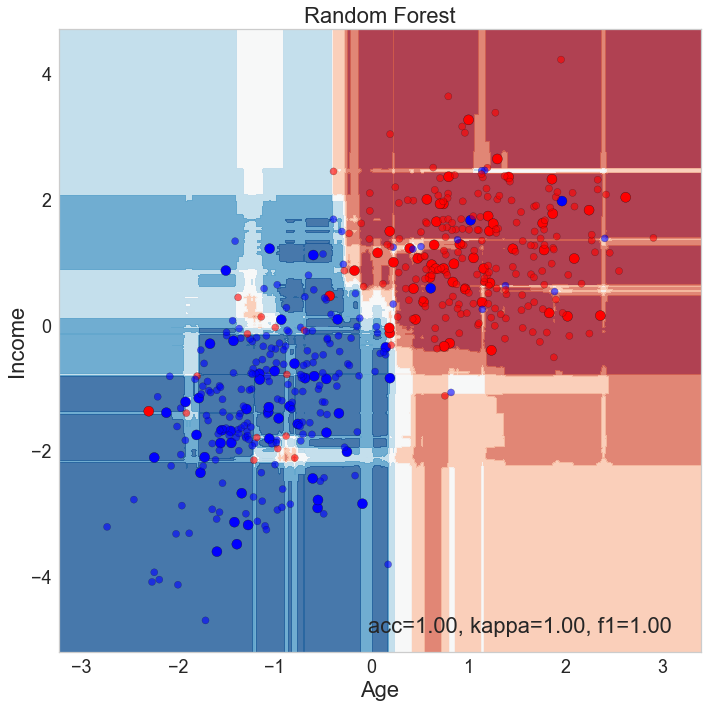

In [13]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_test, X_train, y_test, y_train, clf_rf, "", ax, hide_ticks=False);
ax.set_title("Random Forest", fontsize=22);
ax.set_xlabel("Age", fontsize=22);
ax.set_ylabel("Income", fontsize=22);
plt.tight_layout();
plt.savefig('out/default-rf-boundaries.png');

## Feature Importances

In [14]:
clf_rf.feature_importances_

array([0.5594513, 0.4405487])

In [15]:
values = sorted(zip(feature_names, clf_rf.feature_importances_), key=lambda x: x[1] * -1)
values

[('Age', 0.5594513040145632), ('Income', 0.44054869598543683)]

Wall time: 25.6 s


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D7EB6225F8>,
        cv=5, groups=None, logx=False, model=None, n_jobs=1,
        param_name='n_estimators',
        param_range=array([ 1,  2, ..., 98, 99]), pre_dispatch='all',
        scoring='roc_auc')

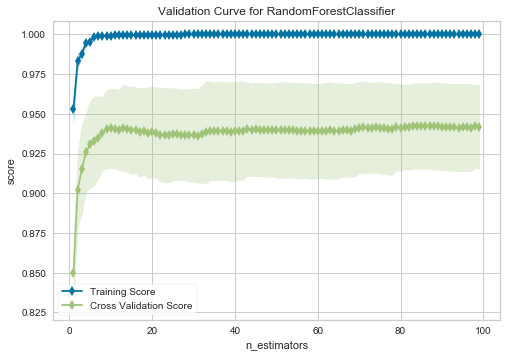

In [16]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(RandomForestClassifier(max_depth=None, min_samples_split=2, random_state=0), param_name="n_estimators", param_range=np.arange(1, 100), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='out/default-rf-n_estimators.png')
viz.poof()

# Extra Trees
 From scikit-learn's docs:
 > In extremely randomized trees (see ExtraTreesClassifier and ExtraTreesRegressor classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias

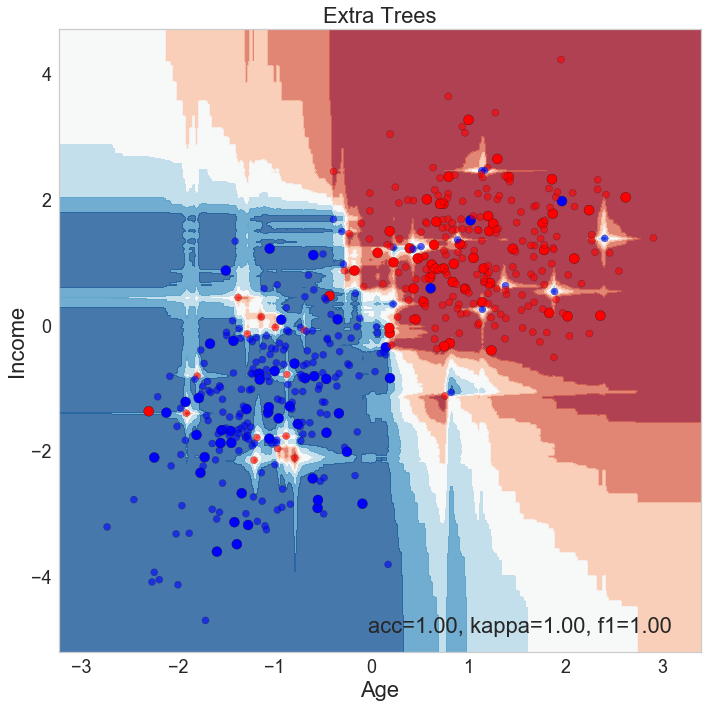

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

clf_et = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf_et.fit(X_train, y_train)

figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_test, X_train, y_test, y_train, clf_et, "", ax, hide_ticks=False);
ax.set_title("Extra Trees", fontsize=22);
ax.set_xlabel("Age", fontsize=22);
ax.set_ylabel("Income", fontsize=22);
plt.tight_layout();
plt.savefig('out/default-extra-boundaries.png');

In [18]:
values = sorted(zip(feature_names, clf_et.feature_importances_), key=lambda x: x[1] * -1)
values

[('Age', 0.6058153016569237), ('Income', 0.39418469834307623)]

Wall time: 23.3 s


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D7EB73EEB8>,
        cv=5, groups=None, logx=False, model=None, n_jobs=1,
        param_name='n_estimators',
        param_range=array([ 1,  2, ..., 98, 99]), pre_dispatch='all',
        scoring='roc_auc')

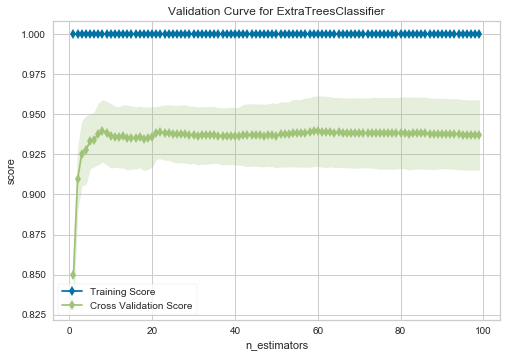

In [19]:
viz = ValidationCurve(ExtraTreesClassifier(max_depth=None, min_samples_split=2, random_state=0), param_name="n_estimators", param_range=np.arange(1, 100), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='out/default-extra-n_estimators.png')
viz.poof()

# Adaboost
From scikit-learn:
> The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights , , …,  to each of the training samples. Initially, those weights are all set to , so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.

In [20]:
from sklearn.ensemble import AdaBoostClassifier

clf_ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1, min_samples_split=2), 
    n_estimators=100, random_state=0)
clf_ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=0)

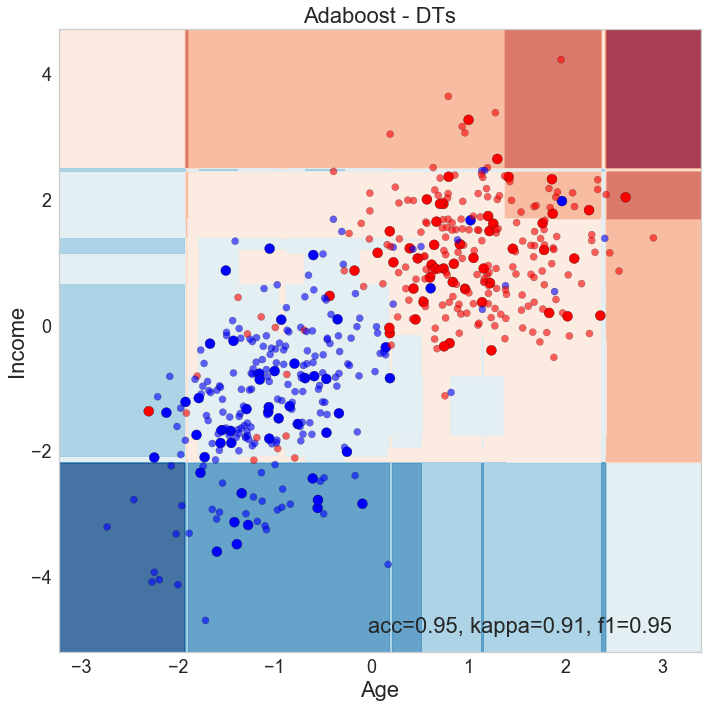

In [21]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_test, X_train, y_test, y_train, clf_ada, "", ax, hide_ticks=False);
ax.set_title("Adaboost - DTs", fontsize=22);
ax.set_xlabel("Age", fontsize=22);
ax.set_ylabel("Income", fontsize=22);
plt.tight_layout();
plt.savefig('out/default-ada-boundaries.png');

Wall time: 27.3 s


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D7EBFB5710>,
        cv=5, groups=None, logx=False, model=None, n_jobs=1,
        param_name='n_estimators',
        param_range=array([ 1,  2, ..., 98, 99]), pre_dispatch='all',
        scoring='roc_auc')

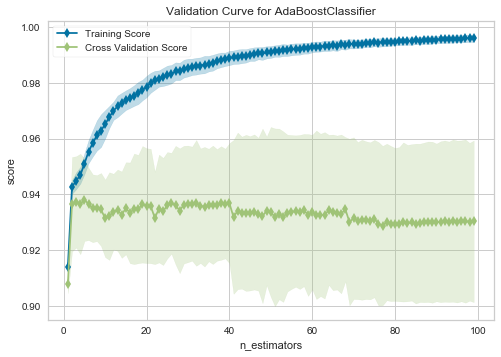

In [22]:
viz = ValidationCurve( AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), random_state=0), param_name="n_estimators", param_range=np.arange(1, 100), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='out/default-ada-n_estimators.png')
viz.poof()

# Gradiant Tree Boosting

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gt = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=1, max_features=1, 
    random_state=0)
clf_gt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=1, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

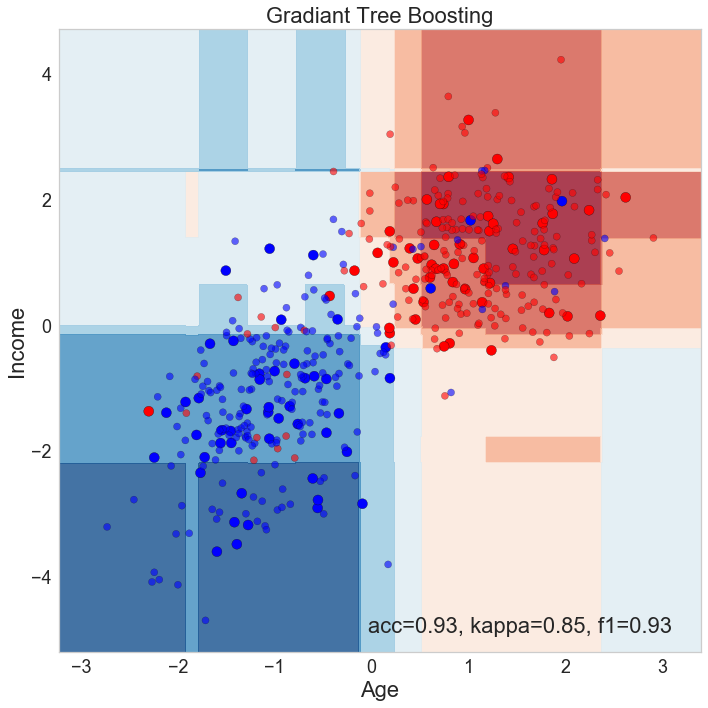

In [24]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_test, X_train, y_test, y_train, clf_gt, "", ax, hide_ticks=False);
ax.set_title("Gradiant Tree Boosting", fontsize=22);
ax.set_xlabel("Age", fontsize=22);
ax.set_ylabel("Income", fontsize=22);
plt.tight_layout();
plt.savefig('out/default-gbm-boundaries.png');

Wall time: 3.61 s


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D7EB19AB70>,
        cv=5, groups=None, logx=False, model=None, n_jobs=1,
        param_name='learning_rate',
        param_range=array([1.00000e-03, 6.99310e-02, 1.38862e-01, 2.07793e-01, 2.76724e-01,
       3.45655e-01, 4.14586e-01, 4.83517e-01, 5.52448e-01, 6.21379e-01,
       6.90310e-01, 7.59241e-01, 8.28172e-01, 8.97103e-01, 9.66034e-01,
       1.03497e+00, 1.10390e+00, 1.17283e+00, 1.24176e+00, 1.31069e+00,
       1.37962e+00, 1.44855e+00, 1.51748e+00, 1.58641e+00, 1.65534e+00,
       1.72428e+00, 1.79321e+00, 1.86214e+00, 1.93107e+00, 2.00000e+00]),
        pre_dispatch='all', scoring='roc_auc')

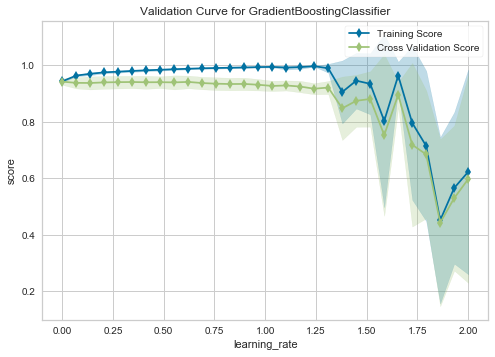

In [25]:
viz = ValidationCurve(GradientBoostingClassifier(n_estimators=100, max_depth=1, max_features=1, random_state=0), param_name="learning_rate", param_range=np.linspace(0.001,2,30), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='out/default-gbm-learning_rate.png')
viz.poof()

Wall time: 6.03 s


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D7EBFC3A90>,
        cv=5, groups=None, logx=False, model=None, n_jobs=1,
        param_name='n_estimators',
        param_range=array([ 1,  2, ..., 98, 99]), pre_dispatch='all',
        scoring='roc_auc')

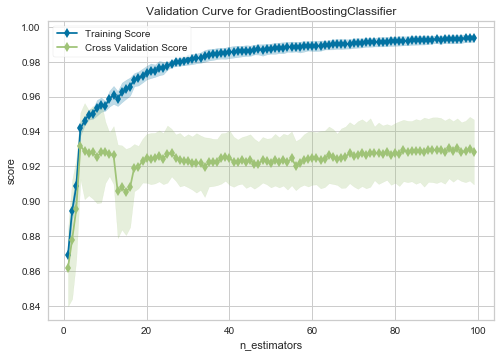

In [26]:
viz = ValidationCurve(GradientBoostingClassifier(learning_rate=1.0, max_depth=1, max_features=1, random_state=0), param_name="n_estimators", param_range=np.arange(1, 100), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='out/default-gbm-n_estimators.png')
viz.poof()

# XGBoost

In [27]:
from xgboost import XGBClassifier
clf_xg = XGBClassifier(n_estimators=100, max_depth=3)
clf_xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

C:\Users\st50\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


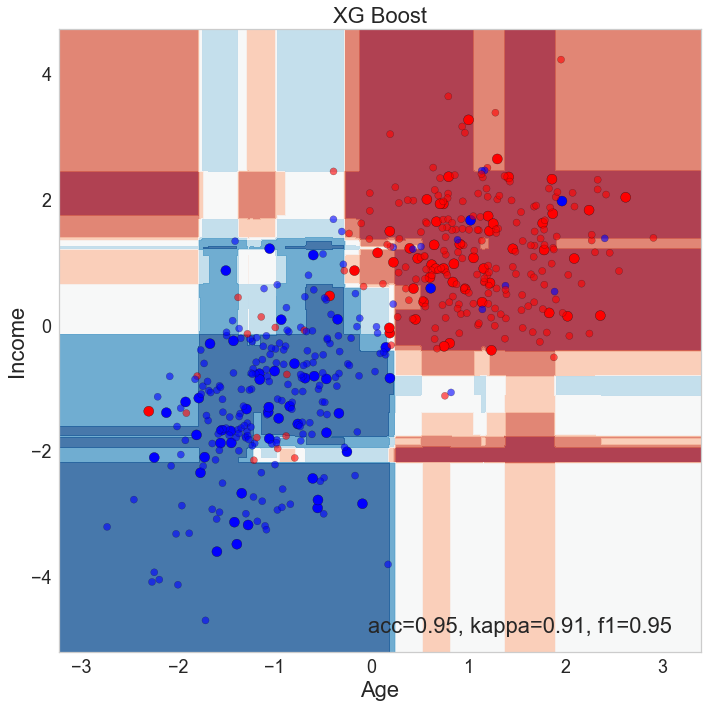

In [28]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_test, X_train, y_test, y_train, clf_xg, "", ax, hide_ticks=False);
ax.set_title("XG Boost", fontsize=22);
ax.set_xlabel("Age", fontsize=22);
ax.set_ylabel("Income", fontsize=22);
plt.tight_layout();
plt.savefig('out/default-xgboost-boundaries.png');

In [29]:
values = sorted(zip(feature_names, clf_xg.feature_importances_), key=lambda x: x[1] * -1)
values

[('Income', 0.53688526), ('Age', 0.46311477)]

Wall time: 3.2 s


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D7EB7FFD30>,
        cv=5, groups=None, logx=False, model=None, n_jobs=1,
        param_name='learning_rate',
        param_range=array([1.00000e-03, 6.99310e-02, 1.38862e-01, 2.07793e-01, 2.76724e-01,
       3.45655e-01, 4.14586e-01, 4.83517e-01, 5.52448e-01, 6.21379e-01,
       6.90310e-01, 7.59241e-01, 8.28172e-01, 8.97103e-01, 9.66034e-01,
       1.03497e+00, 1.10390e+00, 1.17283e+00, 1.24176e+00, 1.31069e+00,
       1.37962e+00, 1.44855e+00, 1.51748e+00, 1.58641e+00, 1.65534e+00,
       1.72428e+00, 1.79321e+00, 1.86214e+00, 1.93107e+00, 2.00000e+00]),
        pre_dispatch='all', scoring='roc_auc')

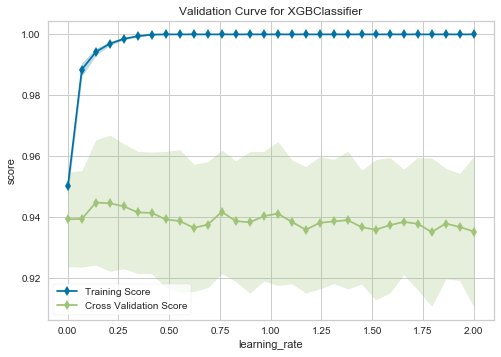

In [30]:
viz = ValidationCurve(XGBClassifier(n_estimators=100, max_depth=3, random_state=0), param_name="learning_rate", param_range=np.linspace(0.001,2,30), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='out/default-xgboost-learning_rate.png')
viz.poof()

Wall time: 6.22 s


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001D7EB7FF320>,
        cv=5, groups=None, logx=False, model=None, n_jobs=1,
        param_name='n_estimators',
        param_range=array([ 1,  2, ..., 98, 99]), pre_dispatch='all',
        scoring='roc_auc')

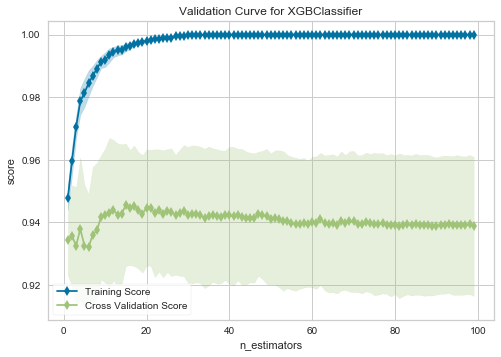

In [31]:
viz = ValidationCurve(XGBClassifier(learning_rate=1.0, max_depth=3, random_state=0), param_name="n_estimators", param_range=np.arange(1, 100), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='out/default-xgboost-n_estimators.png')
viz.poof()

# Stacking
From mlxtend:
> Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble. The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

In [32]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)

classifiers=[('DT', clf1), ('KNN', clf2), ('SVM', clf3)]

sclf = StackingClassifier(
    classifiers=classifiers, meta_classifier=LogisticRegression(), 
    use_probas=True, average_probas=False)

clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)
clf3 = clf3.fit(X_train, y_train)
sclf = cclf.fit(X_train, y_train)

Text(0.5, 1.0, 'DT')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Income')

Text(0.5, 1.0, 'KNN')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Income')

Text(0.5, 1.0, 'SVM')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Income')

C:\Users\st50\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\st50\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5, 1.0, 'Stacking (LR)')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Income')

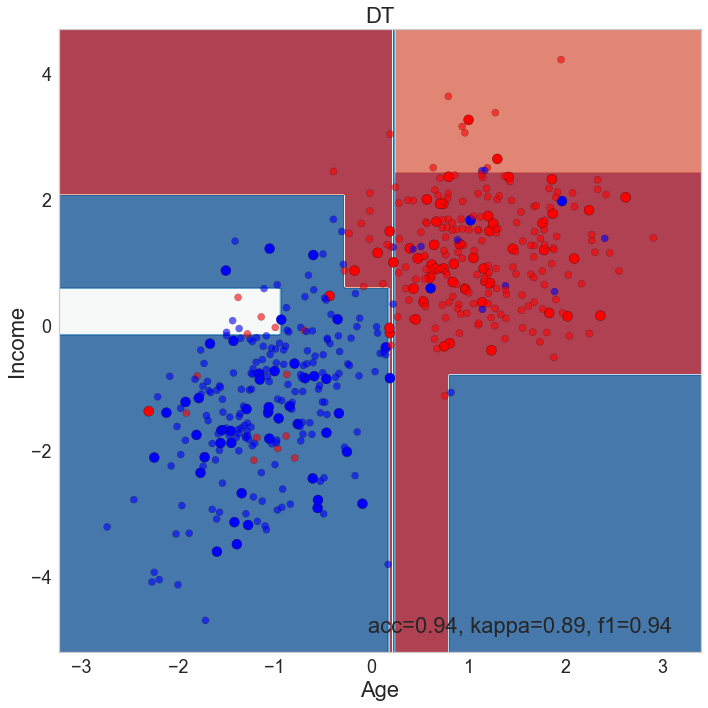

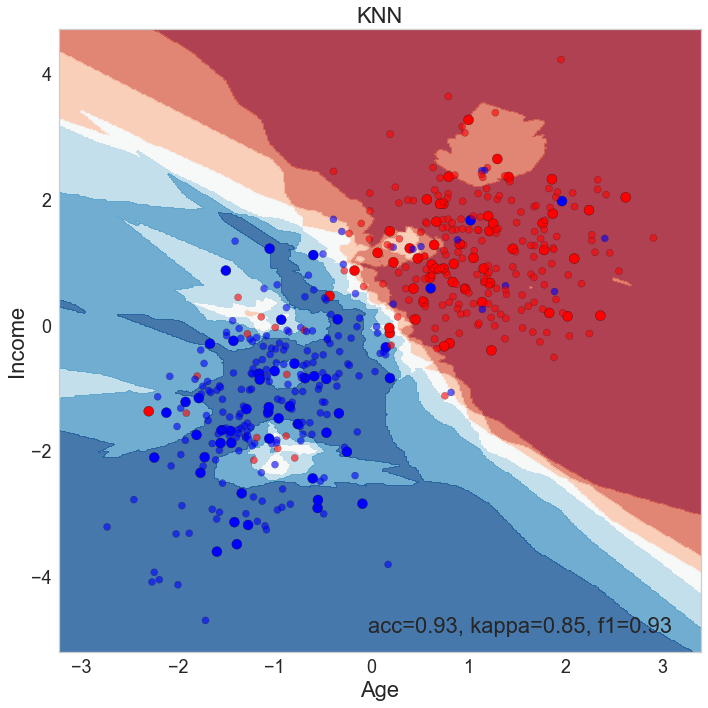

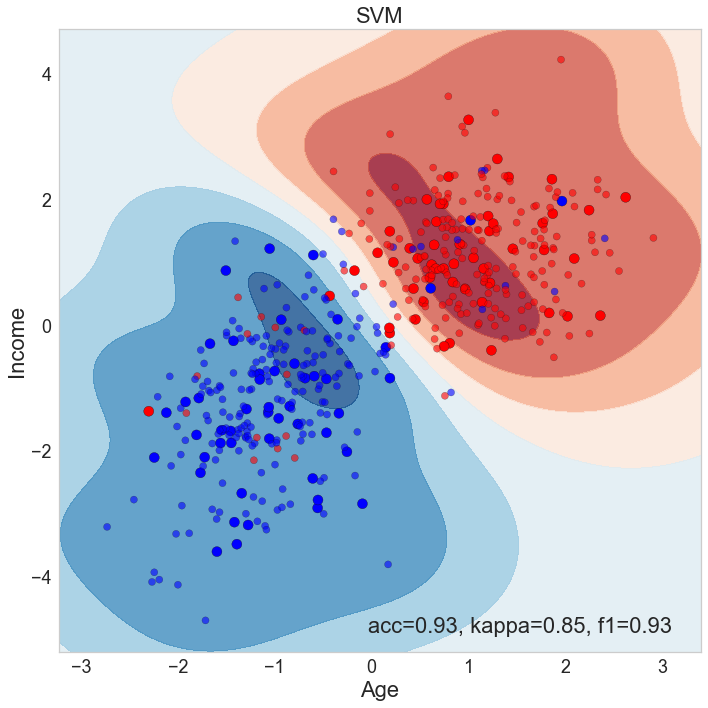

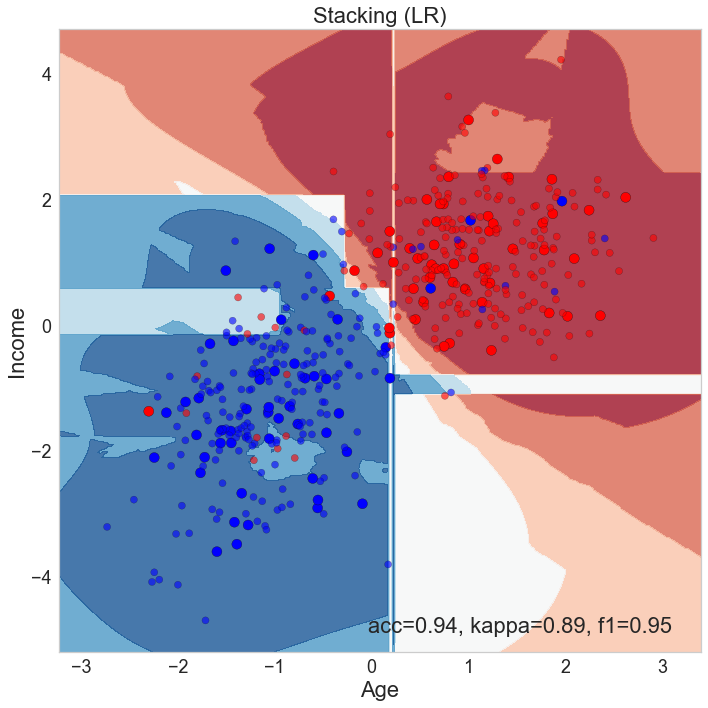

In [33]:
classifiers = classifiers + [('Stacking (LR)', cclf)]

for clf_name, clf_tmp in classifiers:
    y_pred_tmp = clf_tmp.predict(X_test)
    
    figure = plt.figure(figsize=(10, 10));
    ax = plt.subplot(1, 1, 1);
    plot_boundaries(X_test, X_train, y_test, y_train, clf_tmp, "", ax, hide_ticks=False);
    ax.set_title(clf_name, fontsize=22);
    ax.set_xlabel("Age", fontsize=22);
    ax.set_ylabel("Income", fontsize=22);
    plt.tight_layout();
    plt.savefig('out/default-stacking-{}-boundaries.png'.format(clf_name));